# Pre-amble

In [1]:
# loading the required packages
import pandas as pd
import numpy as np
import datetime
import random
import re
import os
import plotnine
from plotnine import *
from rdrobust import rdrobust, rdbwselect, rdplot

# for repeated printouts 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to custom displays of row-column df printouts
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Data load

In [2]:
# first, we load the intake data
intake_bw = pd.read_csv('../data/csv/intake_analysis.csv')

# filtering to only 
intake_bw = intake_bw[(intake_bw.is_black == True) | (intake_bw.is_white == True)].copy()

In [3]:
# now, we load the sentencing data
sentencing_bw = pd.read_csv('../data/csv/sentencing_analysis.csv')

# filtering to only 
sentencing_bw = sentencing_bw[(sentencing_bw.is_black == True) | (sentencing_bw.is_white == True)].copy()

C:\Users\Sean Hambali\AppData\Local\Temp\ipykernel_15556\321909104.py:2: DtypeWarning: Columns (10,11,14,25) have mixed types. Specify dtype option on import or set low_memory=False.


# Regression implementation

In [4]:
# defining a function to get a dataframe of the results (each containing three RD estimates:
# conventional, bias-corrected, and robust)
def rd_regress(yvar, xvar, sample_type):
    result = rdrobust(y = yvar, x = xvar, all = True)

    # initializing the dataframe
    result_df = result.coef

    # merging with other columns to complete the df 
    result_df = result_df.merge(result.se, left_index = True, right_index = True)
    result_df = result_df.merge(result.t, left_index = True, right_index = True)
    result_df = result_df.merge(result.pv, left_index = True, right_index = True)
    result_df = result_df.merge(result.ci, left_index = True, right_index = True)
    result_df['obs_left'] = result.N[0]
    result_df['obs_right'] = result.N[1]
    result_df['bandwidth_days'] = result.bws.loc['h'].values[0]
    result_df['outcome_var'] = yvar.name
    result_df['sample_type'] = sample_type

    # returning the result_df 
    return result_df

In [5]:
# next, we define a function to create RD plot
def rd_plot(yvar, xvar, ytitle, xtitle, title):
    
    # running the rd estimation
    result = rdrobust(y = yvar, x = xvar)
    
    # defining the group subset
    h_l, h_r = result.bws.loc['h', :].values
    subset = ((-h_l <= xvar) & (xvar <= h_r)).values

    # plotting the result
    rd_plot = rdplot(y = yvar, 
                     x = xvar, 
                     subset = subset, 
                     title = title, 
                     x_label = xtitle, 
                     y_label = ytitle)
    return rd_plot

## Felony rejection

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


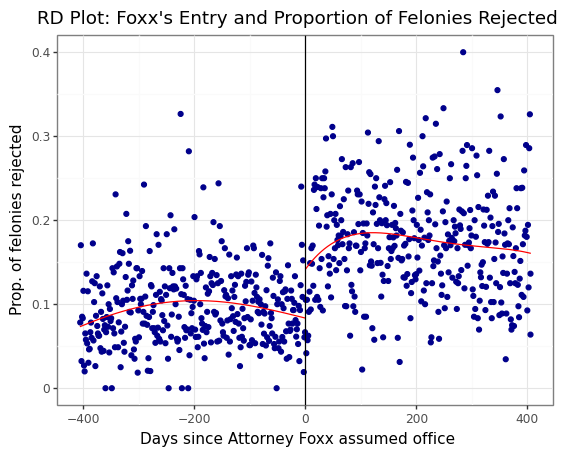

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_fr_is_rejected.png


In [6]:
# getting the descriptive plot
plot1 = rd_plot(yvar = list(map(int, intake_bw.fr_is_rejected)), 
                xvar = intake_bw.sa_timedelta_days, 
                ytitle = "Prop. of felonies rejected", 
                xtitle = "Days since Attorney Foxx assumed office", 
                title = "RD Plot: Foxx's Entry and Proportion of Felonies Rejected")

# saving the plot
plot1.rdplot.save('../output/rd_plot_fr_is_rejected.png', width = 5, height = 5, dpi = 125)

In [7]:
# analyzing the RD impact on probability of felony rejection
fl_reject_full =  rd_regress(yvar = intake_bw.fr_is_rejected, 
                             xvar = intake_bw.sa_timedelta_days, 
                             sample_type='1')
fl_reject_black =  rd_regress(yvar = intake_bw[intake_bw.is_black == True]['fr_is_rejected'], 
                              xvar = intake_bw[intake_bw.is_black == True]['sa_timedelta_days'], 
                              sample_type='2')
fl_reject_white =  rd_regress(yvar = intake_bw[intake_bw.is_black == False]['fr_is_rejected'], 
                              xvar = intake_bw[intake_bw.is_black == False]['sa_timedelta_days'], 
                              sample_type='3')

# appending all results
fl_reject = pd.concat([fl_reject_full, fl_reject_black, fl_reject_white]).reset_index()

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


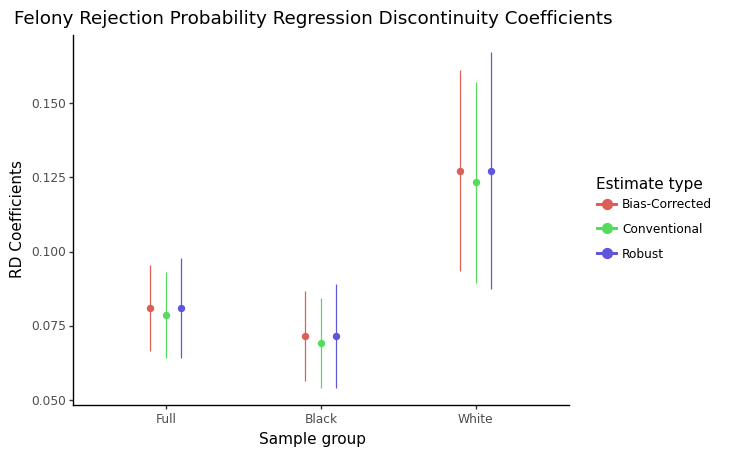

<ggplot: (124018471322)>

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_fl_reject_by_race.png


In [8]:
# plotting the results 
rd_plot_fl_reject_by_race = (
    ggplot(fl_reject, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Felony Rejection Probability Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Full', 'Black', 'White']) +
    theme_classic() +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_fl_reject_by_race

rd_plot_fl_reject_by_race.save('../output/rd_plot_fl_reject_by_race.png', width = 5, height = 5, dpi = 125)

## Felony rejection by crime type

In [9]:
# getting the top 5 felonies in the intake data 
intake_top5_offense = list(intake_bw.UPDATE_OFFENSE_CATEGORY.value_counts()[:5].reset_index()['index'])
intake_top5_offense

['Narcotics',
 'UUW - Unlawful Use of Weapon',
 'Retail Theft',
 'Burglary',
 'Aggravated DUI']

In [10]:
# analyzing the RD impact on probability of felony rejection
fl_reject_narcs =  rd_regress(yvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                               intake_top5_offense[0]]['fr_is_rejected'], 
                              xvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                               intake_top5_offense[0]]['sa_timedelta_days'], 
                              sample_type='1')

fl_reject_uuw =  rd_regress(yvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                             intake_top5_offense[1]]['fr_is_rejected'], 
                            xvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                             intake_top5_offense[1]]['sa_timedelta_days'], 
                            sample_type = '2')

fl_reject_rtheft =  rd_regress(yvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                                intake_top5_offense[2]]['fr_is_rejected'], 
                               xvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                                intake_top5_offense[2]]['sa_timedelta_days'], 
                               sample_type = '3')

fl_reject_burg =  rd_regress(yvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                               intake_top5_offense[3]]['fr_is_rejected'], 
                             xvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                               intake_top5_offense[3]]['sa_timedelta_days'], 
                             sample_type = '4')

fl_reject_agdui =  rd_regress(yvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                               intake_top5_offense[4]]['fr_is_rejected'], 
                              xvar = intake_bw[intake_bw.UPDATE_OFFENSE_CATEGORY == 
                                               intake_top5_offense[4]]['sa_timedelta_days'], 
                              sample_type = '5')

# appending all results
fl_reject_allcrime = pd.concat([fl_reject_narcs, fl_reject_uuw, 
                                fl_reject_rtheft, fl_reject_burg, 
                                fl_reject_agdui]).reset_index()

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [11]:
fl_reject_allcrime

,index,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
0,Conventional,0.152410,0.076092,2.002962,4.518135e-02,0.003272,0.301548,2083,1520,271.731520,fr_is_rejected,1
1,Bias-Corrected,0.184808,0.076092,2.428738,1.515149e-02,0.035670,0.333946,2083,1520,271.731520,fr_is_rejected,1
2,Robust,0.184808,0.085794,2.154082,3.123375e-02,0.016654,0.352962,2083,1520,271.731520,fr_is_rejected,1
3,Conventional,0.013800,0.010270,1.343722,1.790383e-01,-0.006329,0.033928,15986,28208,622.719055,fr_is_rejected,2
4,Bias-Corrected,0.011201,0.010270,1.090714,2.753986e-01,-0.008927,0.031329,15986,28208,622.719055,fr_is_rejected,2
5,Robust,0.011201,0.012060,0.928778,3.530041e-01,-0.012436,0.034839,15986,28208,622.719055,fr_is_rejected,2
6,Conventional,0.338552,0.024994,13.545559,8.417084e-42,0.289566,0.387539,18276,8228,289.792528,fr_is_rejected,3
7,Bias-Corrected,0.326369,0.024994,13.058110,5.712846e-39,0.277383,0.375356,18276,8228,289.792528,fr_is_rejected,3
8,Robust,0.326369,0.027258,11.973416,4.897034e-33,0.272945,0.379794,18276,8228,289.792528,fr_is_rejected,3
9,Conventional,0.029468,0.017580,1.676185,9.370193e-02,-0.004989,0.063924,7574,4822,792.792155,fr_is_rejected,4


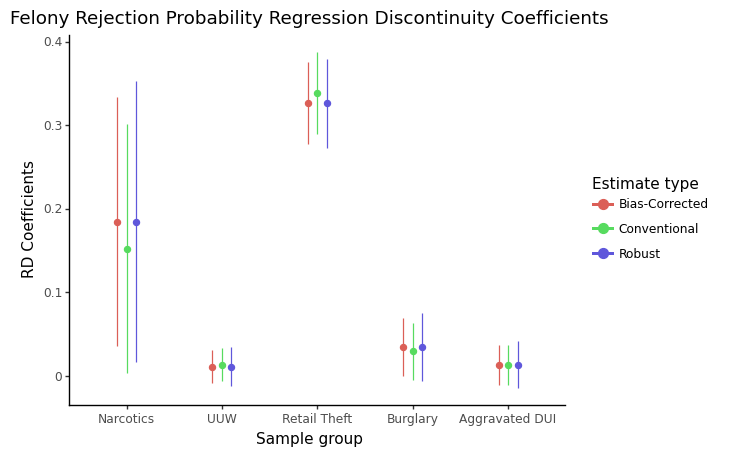

<ggplot: (124019179081)>

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_fl_reject_by_crime.png


In [12]:
# plotting the results 
rd_plot_fl_reject_by_crime = (
    ggplot(fl_reject_allcrime, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Felony Rejection Probability Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Narcotics', 'UUW', 'Retail Theft', 'Burglary', 'Aggravated DUI']) +
    theme_classic() +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_fl_reject_by_crime

rd_plot_fl_reject_by_crime.save('../output/rd_plot_fl_reject_by_crime.png', width = 5, height = 5, dpi = 125)

## Incarceration

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


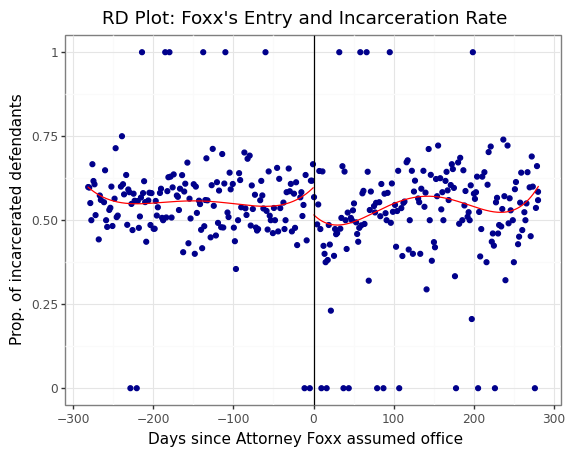

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_incarcerated_prop.png


In [13]:
# getting the descriptive plot
plot2 = rd_plot(yvar = list(map(int, sentencing_bw.is_incarcerated)), 
                xvar = sentencing_bw.sa_timedelta_days, 
                ytitle = "Prop. of incarcerated defendants", 
                xtitle = "Days since Attorney Foxx assumed office", 
                title = "RD Plot: Foxx's Entry and Incarceration Rate")

# saving the plot
plot2.rdplot.save('../output/rd_plot_incarcerated_prop.png', width = 5, height = 5, dpi = 125)

In [14]:
# analyzing the RD impact on probability of incarceration
inc_full =  rd_regress(yvar = sentencing_bw.is_incarcerated, 
                       xvar = sentencing_bw.sa_timedelta_days, 
                       sample_type='1')

inc_black =  rd_regress(yvar = sentencing_bw[sentencing_bw.is_black == True]['is_incarcerated'], 
                        xvar = sentencing_bw[sentencing_bw.is_black == True]['sa_timedelta_days'], 
                        sample_type='2')

inc_white =  rd_regress(yvar = sentencing_bw[sentencing_bw.is_black == False]['is_incarcerated'], 
                        xvar = sentencing_bw[sentencing_bw.is_black == False]['sa_timedelta_days'], 
                        sample_type='3')

# appending all results
inc_df = pd.concat([inc_full, inc_black, inc_white]).reset_index()
inc_df

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


,index,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
0,Conventional,-0.061157,0.014691,-4.162964,0.000031,-0.089950,-0.032363,96749,53496,282.435894,is_incarcerated,1
1,Bias-Corrected,-0.067895,0.014691,-4.621644,0.000004,-0.096688,-0.039102,96749,53496,282.435894,is_incarcerated,1
2,Robust,-0.067895,0.016193,-4.192954,0.000028,-0.099632,-0.036158,96749,53496,282.435894,is_incarcerated,1
3,Conventional,-0.046607,0.015114,-3.083626,0.002045,-0.076230,-0.016983,78353,44545,324.449424,is_incarcerated,2
4,Bias-Corrected,-0.053005,0.015114,-3.506940,0.000453,-0.082628,-0.023381,78353,44545,324.449424,is_incarcerated,2
5,Robust,-0.053005,0.017058,-3.107354,0.001888,-0.086438,-0.019572,78353,44545,324.449424,is_incarcerated,2
6,Conventional,-0.051800,0.024677,-2.099115,0.035807,-0.100167,-0.003434,18396,8951,489.501985,is_incarcerated,3
7,Bias-Corrected,-0.061191,0.024677,-2.479659,0.013151,-0.109558,-0.012825,18396,8951,489.501985,is_incarcerated,3
8,Robust,-0.061191,0.028167,-2.172460,0.029821,-0.116397,-0.005985,18396,8951,489.501985,is_incarcerated,3


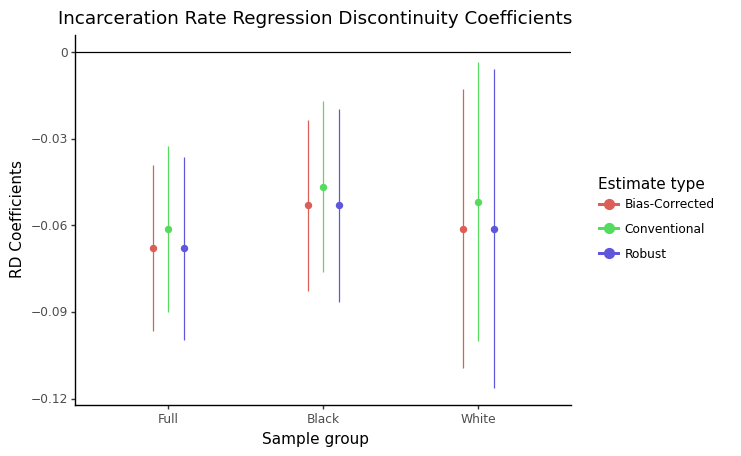

<ggplot: (124019662574)>

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_incarcerated_by_race


In [15]:
# plotting the results 
rd_plot_incarcerated_by_race = (
    ggplot(inc_df, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    geom_hline(aes(yintercept = 0)) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Incarceration Rate Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Full', 'Black', 'White']) +
    theme_classic() +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_incarcerated_by_race

# saving the plot
rd_plot_incarcerated_by_race.save('../output/rd_plot_incarcerated_by_race', width = 5, height = 5, dpi = 125)

## Sentencing length

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


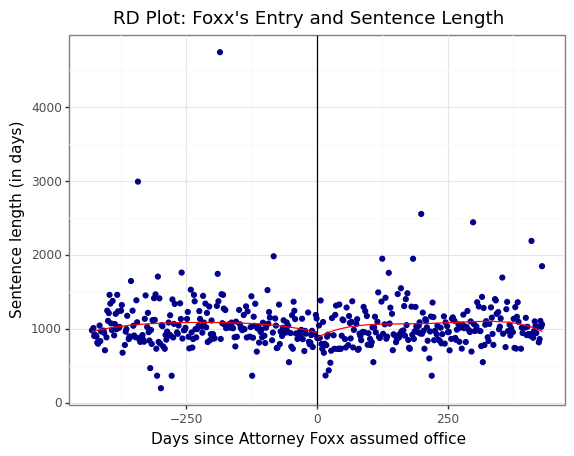

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_sentence_length.png


In [16]:
# getting the descriptive plot
plot3 = rd_plot(yvar = sentencing_bw.sentencing_term_d, 
                xvar = sentencing_bw.sa_timedelta_days, 
                ytitle = "Sentence length (in days)", 
                xtitle = "Days since Attorney Foxx assumed office", 
                title = "RD Plot: Foxx's Entry and Sentence Length")

# saving the plot
plot3.rdplot.save('../output/rd_plot_sentence_length.png', width = 5, height = 5, dpi = 125)

In [17]:
# analyzing the RD impact on sentencing length
sen_length_full =  rd_regress(yvar = sentencing_bw.sentencing_term_d, 
                              xvar = sentencing_bw.sa_timedelta_days, 
                              sample_type='1')

sen_length_black =  rd_regress(yvar = sentencing_bw[sentencing_bw.is_black == True]['sentencing_term_d'], 
                               xvar = sentencing_bw[sentencing_bw.is_black == True]['sa_timedelta_days'], 
                               sample_type='2')

sen_length_white =  rd_regress(yvar = sentencing_bw[sentencing_bw.is_black == False]['sentencing_term_d'], 
                               xvar = sentencing_bw[sentencing_bw.is_black == False]['sa_timedelta_days'], 
                               sample_type='3')

# appending all results
sen_length_df = pd.concat([sen_length_full, sen_length_black, sen_length_white]).reset_index()
sen_length_df

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


,index,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
0,Conventional,-40.005720,33.403044,-1.197667,0.231047,-105.474484,25.463044,95809,53412,431.831280,sentencing_term_d,1
1,Bias-Corrected,-46.399667,33.403044,-1.389085,0.164807,-111.868431,19.069097,95809,53412,431.831280,sentencing_term_d,1
2,Robust,-46.399667,39.357170,-1.178938,0.238423,-123.538304,30.738969,95809,53412,431.831280,sentencing_term_d,1
3,Conventional,-43.439014,38.224411,-1.136421,0.255781,-118.357483,31.479455,77474,44472,442.169065,sentencing_term_d,2
4,Bias-Corrected,-51.883818,38.224411,-1.357348,0.174671,-126.802287,23.034651,77474,44472,442.169065,sentencing_term_d,2
5,Robust,-51.883818,44.853879,-1.156730,0.247383,-139.795806,36.028169,77474,44472,442.169065,sentencing_term_d,2
6,Conventional,-22.929461,59.319797,-0.386540,0.699097,-139.194126,93.335205,18335,8940,474.440303,sentencing_term_d,3
7,Bias-Corrected,-44.090286,59.319797,-0.743264,0.457322,-160.354952,72.174379,18335,8940,474.440303,sentencing_term_d,3
8,Robust,-44.090286,67.616659,-0.652062,0.514361,-176.616502,88.435930,18335,8940,474.440303,sentencing_term_d,3


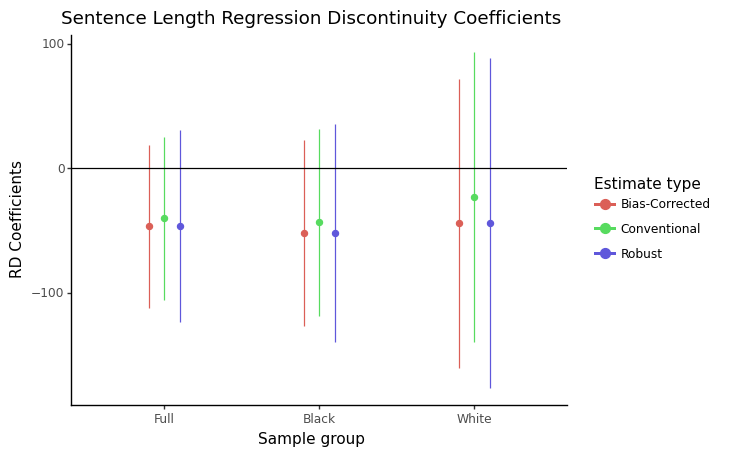

<ggplot: (124021395104)>

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_sen_length_by_race


In [18]:
# plotting the results 
rd_plot_sen_length_by_race = (
    ggplot(sen_length_df, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    geom_hline(aes(yintercept = 0)) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Sentence Length Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Full', 'Black', 'White']) +
    theme_classic() +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_sen_length_by_race

# saving the plot
rd_plot_sen_length_by_race.save('../output/rd_plot_sen_length_by_race', width = 5, height = 5, dpi = 125)

## Probation

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


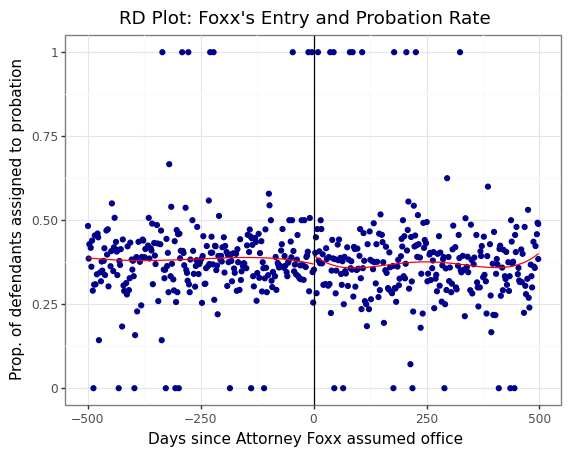

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_probation_prop.png


In [19]:
# getting the descriptive plot
plot4 = rd_plot(yvar = list(map(int, sentencing_bw.is_on_probation)), 
                xvar = sentencing_bw.sa_timedelta_days, 
                ytitle = "Prop. of defendants assigned to probation", 
                xtitle = "Days since Attorney Foxx assumed office", 
                title = "RD Plot: Foxx's Entry and Probation Rate")

# saving the plot
plot4.rdplot.save('../output/rd_plot_probation_prop.png', width = 5, height = 5, dpi = 125)

In [20]:
# analyzing the RD impact on sentencing length
prob_full =  rd_regress(yvar = sentencing_bw.is_on_probation, 
                        xvar = sentencing_bw.sa_timedelta_days, 
                        sample_type='1')

prob_black =  rd_regress(yvar = sentencing_bw[sentencing_bw.is_black == True]['is_on_probation'], 
                         xvar = sentencing_bw[sentencing_bw.is_black == True]['sa_timedelta_days'], 
                         sample_type='2')

prob_white =  rd_regress(yvar = sentencing_bw[sentencing_bw.is_black == False]['is_on_probation'], 
                         xvar = sentencing_bw[sentencing_bw.is_black == False]['sa_timedelta_days'], 
                         sample_type='3')

# appending all results
prob_df = pd.concat([prob_full, prob_black, prob_white]).reset_index()

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


,index,Coeff,Std. Err.,t-stat.,P>|t|,CI Lower,CI Upper,obs_left,obs_right,bandwidth_days,outcome_var,sample_type
0,Conventional,-0.012500,0.010859,-1.151139,0.249675,-0.033783,0.008783,96749,53496,500.774281,is_on_probation,1
1,Bias-Corrected,-0.008629,0.010859,-0.794654,0.426815,-0.029912,0.012654,96749,53496,500.774281,is_on_probation,1
2,Robust,-0.008629,0.012481,-0.691345,0.489349,-0.033092,0.015834,96749,53496,500.774281,is_on_probation,1
3,Conventional,-0.010905,0.012434,-0.876999,0.380487,-0.035275,0.013466,78353,44545,451.777527,is_on_probation,2
4,Bias-Corrected,-0.006011,0.012434,-0.483453,0.628774,-0.030381,0.018359,78353,44545,451.777527,is_on_probation,2
5,Robust,-0.006011,0.014105,-0.426173,0.669982,-0.033657,0.021634,78353,44545,451.777527,is_on_probation,2
6,Conventional,-0.022845,0.025502,-0.895787,0.370367,-0.072828,0.027139,18396,8951,487.208866,is_on_probation,3
7,Bias-Corrected,-0.029937,0.025502,-1.173903,0.240434,-0.079920,0.020046,18396,8951,487.208866,is_on_probation,3
8,Robust,-0.029937,0.029942,-0.999829,0.317393,-0.088623,0.028749,18396,8951,487.208866,is_on_probation,3


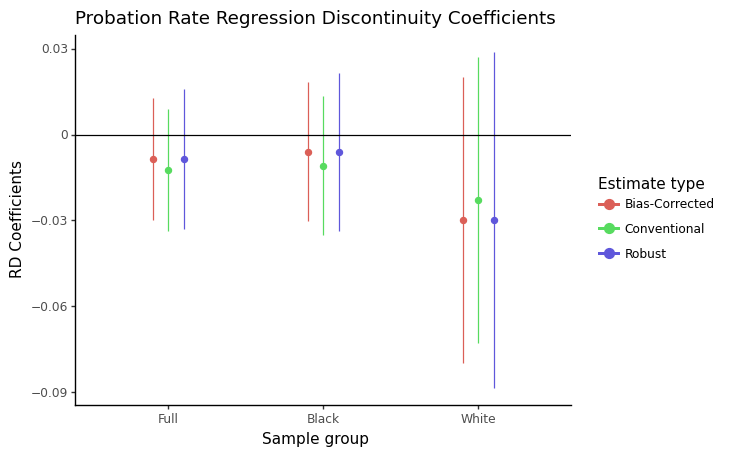

<ggplot: (124021878556)>

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_probation_by_race


In [21]:
# plotting the results 
rd_plot_probation_by_race = (
    ggplot(prob_df, aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    geom_hline(aes(yintercept = 0)) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Probation Rate Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Full', 'Black', 'White']) +
    theme_classic() +
    guides(color = guide_legend(title = 'Estimate type'))
)

# showing the plot
rd_plot_probation_by_race

# saving the plot
rd_plot_probation_by_race.save('../output/rd_plot_probation_by_race', width = 5, height = 5, dpi = 125)

# Discontinuity in characteristics around the cutoff in the intake data?

In [35]:
# converting bool to numeric as RDrobust doesnt work nicely with bool?
intake_bw['is_black_int'] = np.where(intake_bw.is_black == True, 1, 0)
intake_bw['is_female_int'] = np.where(intake_bw.is_female == True, 1, 0)

# generating indicators for top 5 crimes ?
intake_bw['is_narc_offense'] = np.where(intake_bw.UPDATE_OFFENSE_CATEGORY == 'Narcotics', 1, 0)
intake_bw['is_uuw_offense'] = np.where(intake_bw.UPDATE_OFFENSE_CATEGORY == 'UUW - Unlawful Use of Weapon', 1, 0)
intake_bw['is_rtheft_offense'] = np.where(intake_bw.UPDATE_OFFENSE_CATEGORY == 'Retail Theft', 1, 0)
intake_bw['is_burg_offense'] = np.where(intake_bw.UPDATE_OFFENSE_CATEGORY == 'Burglary', 1, 0)
intake_bw['is_agdui_offense'] = np.where(intake_bw.UPDATE_OFFENSE_CATEGORY == 'Aggravated DUI', 1, 0)

In [33]:
# discontinuity in black proportion ?
race_full = rd_regress(yvar = intake_bw.is_black_int, 
                       xvar = intake_bw.sa_timedelta_days, 
                       sample_type='1')

# discontinuity in age ?
age_full =  rd_regress(yvar = intake_bw.age_cleaned, 
                       xvar = intake_bw.sa_timedelta_days, 
                       sample_type='1')

age_black =  rd_regress(yvar = intake_bw[intake_bw.is_black == True]['age_cleaned'], 
                        xvar = intake_bw[intake_bw.is_black == True]['sa_timedelta_days'], 
                        sample_type='2')

age_white =  rd_regress(yvar = intake_bw[intake_bw.is_black == False]['age_cleaned'], 
                        xvar = intake_bw[intake_bw.is_black == False]['sa_timedelta_days'], 
                        sample_type='3')


# discontinuity in gender prop? 
sex_full =  rd_regress(yvar = intake_bw.is_female_int, 
                       xvar = intake_bw.sa_timedelta_days, 
                       sample_type='1')

sex_black =  rd_regress(yvar = intake_bw[intake_bw.is_black == True]['is_female_int'], 
                        xvar = intake_bw[intake_bw.is_black == True]['sa_timedelta_days'], 
                        sample_type='2')

sex_white =  rd_regress(yvar = intake_bw[intake_bw.is_black == False]['is_female_int'], 
                        xvar = intake_bw[intake_bw.is_black == False]['sa_timedelta_days'], 
                        sample_type='3')

# concatting above dfs 
chars_df = pd.concat([race_full, 
                      age_full, age_black, age_white, 
                      sex_full, sex_black, sex_white])

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


In [36]:
# discontinuity in crime types ?
cols = ['is_narc_offense', 'is_uuw_offense', 'is_rtheft_offense', 
        'is_burg_offense', 'is_agdui_offense']

# initiating empty df
offenses_df = pd.DataFrame()

# for loop 
for offense in cols:
    
    # for full sample regression
    df_full = rd_regress(yvar = intake_bw[offense], 
                         xvar = intake_bw['sa_timedelta_days'], 
                         sample_type='1')
    
    # for blacks sample regression
    df_black = rd_regress(yvar = intake_bw[intake_bw.is_black == True][offense], 
                          xvar = intake_bw[intake_bw.is_black == True]['sa_timedelta_days'], 
                          sample_type='2')
    
    # for white sample regression
    df_white = rd_regress(yvar = intake_bw[intake_bw.is_black == False][offense], 
                          xvar = intake_bw[intake_bw.is_black == False]['sa_timedelta_days'], 
                          sample_type='3')
    
    # concat init df with all above df
    offenses_df = pd.concat([offenses_df, df_full, df_black, df_white])

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the runnin

C:\Users\Public\anaconda3\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


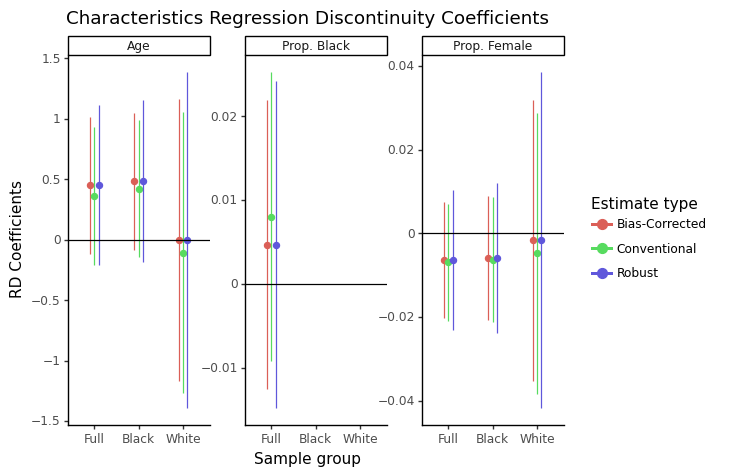

<ggplot: (124041226466)>

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_discont_chars.png
C:\Users\Public\anaconda3\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


In [55]:
# creating new column for facet labels
chars_df['facets'] = np.where(chars_df.outcome_var == "is_black_int", "Prop. Black", 
                              np.where(chars_df.outcome_var == "age_cleaned", "Age", "Prop. Female"))

# plotting the results - characteristics discontinuity
rd_plot_discont_chars =(
    ggplot(chars_df.reset_index(), aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    geom_hline(aes(yintercept = 0)) +
    facet_wrap("facets", scales = "free_y") +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Characteristics Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Full', 'Black', 'White']) +
    theme_classic() +
    theme(panel_spacing=.35) +
    guides(color = guide_legend(title = 'Estimate type'))
)

# display
rd_plot_discont_chars

# save
rd_plot_discont_chars.save('../output/rd_plot_discont_chars.png', width = 5, height = 5, dpi = 125)


C:\Users\Public\anaconda3\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


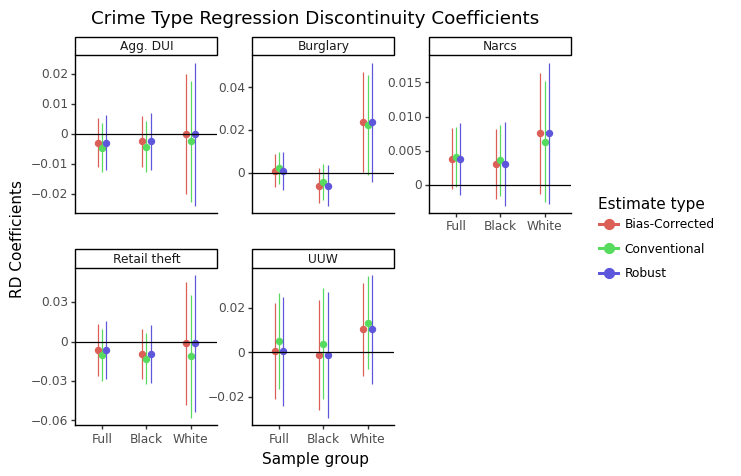

<ggplot: (124031989995)>

C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\Public\anaconda3\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: ../output/rd_plot_discont_offense.png
C:\Users\Public\anaconda3\lib\site-packages\plotnine\facets\facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


In [54]:
# creating new column for facet labels
offenses_df['facets'] = np.where(offenses_df.outcome_var == "is_narc_offense", "Narcs", 
                                 np.where(offenses_df.outcome_var == "is_uuw_offense", "UUW", 
                                          np.where(offenses_df.outcome_var == "is_rtheft_offense", "Retail theft", 
                                                   np.where(offenses_df.outcome_var == "is_burg_offense", "Burglary", 
                                                            "Agg. DUI"))))

# plotting the results - crimes discontinuity
rd_plot_discont_offense = (
    ggplot(offenses_df.reset_index(), aes(x = 'sample_type', y = 'Coeff', color = 'index')) +
    geom_pointrange(aes(ymin = 'CI Lower', ymax = 'CI Upper'), position = position_dodge(width = .3)) +
    geom_hline(aes(yintercept = 0)) +
    facet_wrap("facets", scales = "free_y", nrow = 2) +
    labs(x = 'Sample group', y = 'RD Coefficients', title = 'Crime Type Regression Discontinuity Coefficients') +
    scale_x_discrete(labels = ['Full', 'Black', 'White']) +
    theme_classic() +
    theme(panel_spacing=.35) +
    guides(color = guide_legend(title = 'Estimate type'))
)

# display
rd_plot_discont_offense

# save
rd_plot_discont_offense.save('../output/rd_plot_discont_offense.png', width = 5, height = 5, dpi = 125)